## Web Scrapping Project 

In [ ]:
!pip install selenium

## Libraries Used

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import pyodbc

## Scrapping data using selenium & Loading the data into SQL using pyodbc

In [ ]:


conn = pyodbc.connect(
     "DRIVER={ODBC Driver 17 for SQL Server};"
     "SERVER=DESKTOP-VE7A4J6;"
     "DATABASE=coinMarket;"
     "Trusted_Connection=yes;"
 )
cursor = conn.cursor()
print("Connected to SQL Server")

options = Options()
options.add_argument("--start-maximized")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

all_crypto_data = []
TOTAL_PAGES = 3

for page in range(1, TOTAL_PAGES + 1):
    url = f"https://coinmarketcap.com/?page={page}"
    print(f"📄 Scraping page {page}")

    driver.get(url)
    time.sleep(3)

    scroll_pause_time = 0.5
    scroll_step = 1000
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        for i in range(0, last_height, scroll_step):
            driver.execute_script(f"window.scrollTo(0, {i});")
            time.sleep(scroll_pause_time)

        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    soup = BeautifulSoup(driver.page_source, "html.parser")
    table = soup.find('table', {'class': 'cmc-table'})

    if not table:
        print("⚠️ Table not found, skipping page")
        continue

    rows = table.find_all('tr')

    for row in rows[1:]:
        cols = row.find_all('td')
        if len(cols) >= 10:
            rank = cols[1].text.strip()
            name = cols[2].text.strip()
            price = cols[3].text.strip()
            one_hour_change = cols[4].text.strip()
            twenty_four_hour_change = cols[5].text.strip()
            seven_day_change = cols[6].text.strip()
            market_cap = cols[7].text.strip()
            hr_volume = cols[8].text.strip()
            circulating_supply = cols[9].text.strip()

            all_crypto_data.append((
                rank, name, price, one_hour_change,
                twenty_four_hour_change, seven_day_change,
                market_cap, hr_volume, circulating_supply
            ))

driver.quit()
print(f"Total coins scraped: {len(all_crypto_data)}")

insert_query = """
INSERT INTO coinMarketData.crypto_market (
    rank_no, name, price, one_hour_change,
    twenty_four_hour_change, seven_day_change,
    market_cap, hr_volume, circulating_supply
)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)

"""

cursor.executemany(insert_query, all_crypto_data)
conn.commit()

print("🚀 Data successfully inserted into SQL Server!")

cursor.close()
conn.close()

Connected to SQL Server
📄 Scraping page 1
📄 Scraping page 2
📄 Scraping page 3
Total coins scraped: 301
🚀 Data successfully inserted into SQL Server!


## Result Obtained:

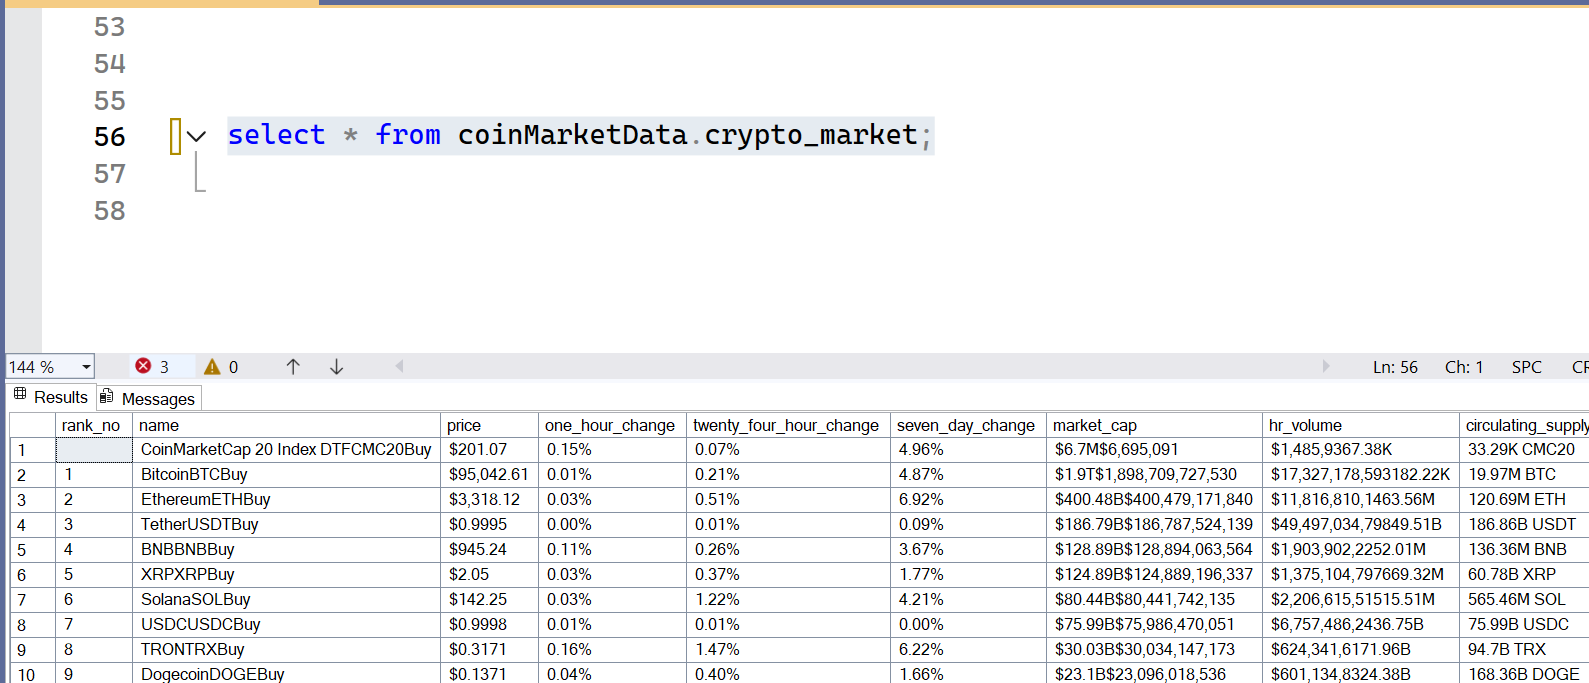